<a href="https://colab.research.google.com/github/zawarudobngdev/face_detection/blob/master/Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import imutils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript

import tarfile

from base64 import b64decode
from google.colab.output import eval_js


### downloading and unzipping LFW - People Kaggle Dataset

In [ ]:
!kaggle datasets download -d atulanandjha/lfwpeople

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
 98% 227M/232M [00:07<00:00, 22.8MB/s]
100% 232M/232M [00:07<00:00, 34.6MB/s]


In [ ]:
!unzip lfwpeople.zip

Archive:  lfwpeople.zip
  inflating: lfw-funneled.tgz        
  inflating: pairs.txt               
  inflating: pairsDevTest.txt        
  inflating: pairsDevTrain.txt       


## FaceDetector Class

In [15]:
class FaceDetector():
    def __init__(self,faceCascadePath):
        self.faceCascade=cv2.CascadeClassifier(faceCascadePath)


    def detect(self, image, scaleFactor=1.1,
               minNeighbors=5,
               minSize=(30,30)):

        #function return rectangle coordinates of faces for given image
        rects=self.faceCascade.detectMultiScale(image,
                                                scaleFactor=scaleFactor,
                                                minNeighbors=minNeighbors,
                                                minSize=minSize)
        return rects

In [6]:
def show_image(image):
    plt.figure(figsize=(18,15))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

## FetchLFW class

In [7]:
class FetchLFW:
    def __init__(self, path):
        self.path=path

    def _initialize(self,dim):
        self.dim_of_photo_gallery=dim
        self.number_of_images=self.dim_of_photo_gallery*self.dim_of_photo_gallery

        total_number_of_image=13233
        self.random_face_indexes=np.arange(total_number_of_image)
        np.random.shuffle(self.random_face_indexes)
        self.n_random_face_indexes=self.random_face_indexes[:self.number_of_images]

    def get_lfw_images(self,dim=5):

        self._initialize(dim)


        self.lfw_images=self._get_images()

        return self.lfw_images


    def _get_images(self):
        image_list=[]
        tar = tarfile.open(path, "r:gz")
        counter=0
        for tarinfo in tar:

            tar.extract(tarinfo.name)
            if tarinfo.name[-4:]==".jpg":
                if counter in self.n_random_face_indexes:
                    image=cv2.imread(tarinfo.name, cv2.IMREAD_COLOR)
                    image=cv2.resize(image,None,fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
                    image_list.append(np.array(image))
                counter+=1
            if tarinfo.isdir():
                pass
            else:
                os.remove(tarinfo.name)
        tar.close()

        return np.array(image_list)

### Fetching LFW Images

In [8]:
path="/content/lfw-funneled.tgz"
fetchLFW=FetchLFW(path)
dimension=10
images=fetchLFW.get_lfw_images(dim=dimension)
print("LFW images have been fetched")

LFW images have been fetched


In [9]:
print(images.shape)

(100, 100, 100, 3)


## Helper Function: get_photo_gallery()

In [10]:
def get_photo_gallery():
    counter=0
    himages=[]
    vimages=[]
    for i in range(dimension):
        for j in range(dimension):

            himages.append(images[counter])
            counter+=1

        himage=np.hstack((himages))
        vimages.append(himage)
        himages=[]
    image_matrix=np.vstack((vimages))
    return image_matrix

### Showing Images as Photo Gallery

photo_gallery:(1000, 1000, 3)


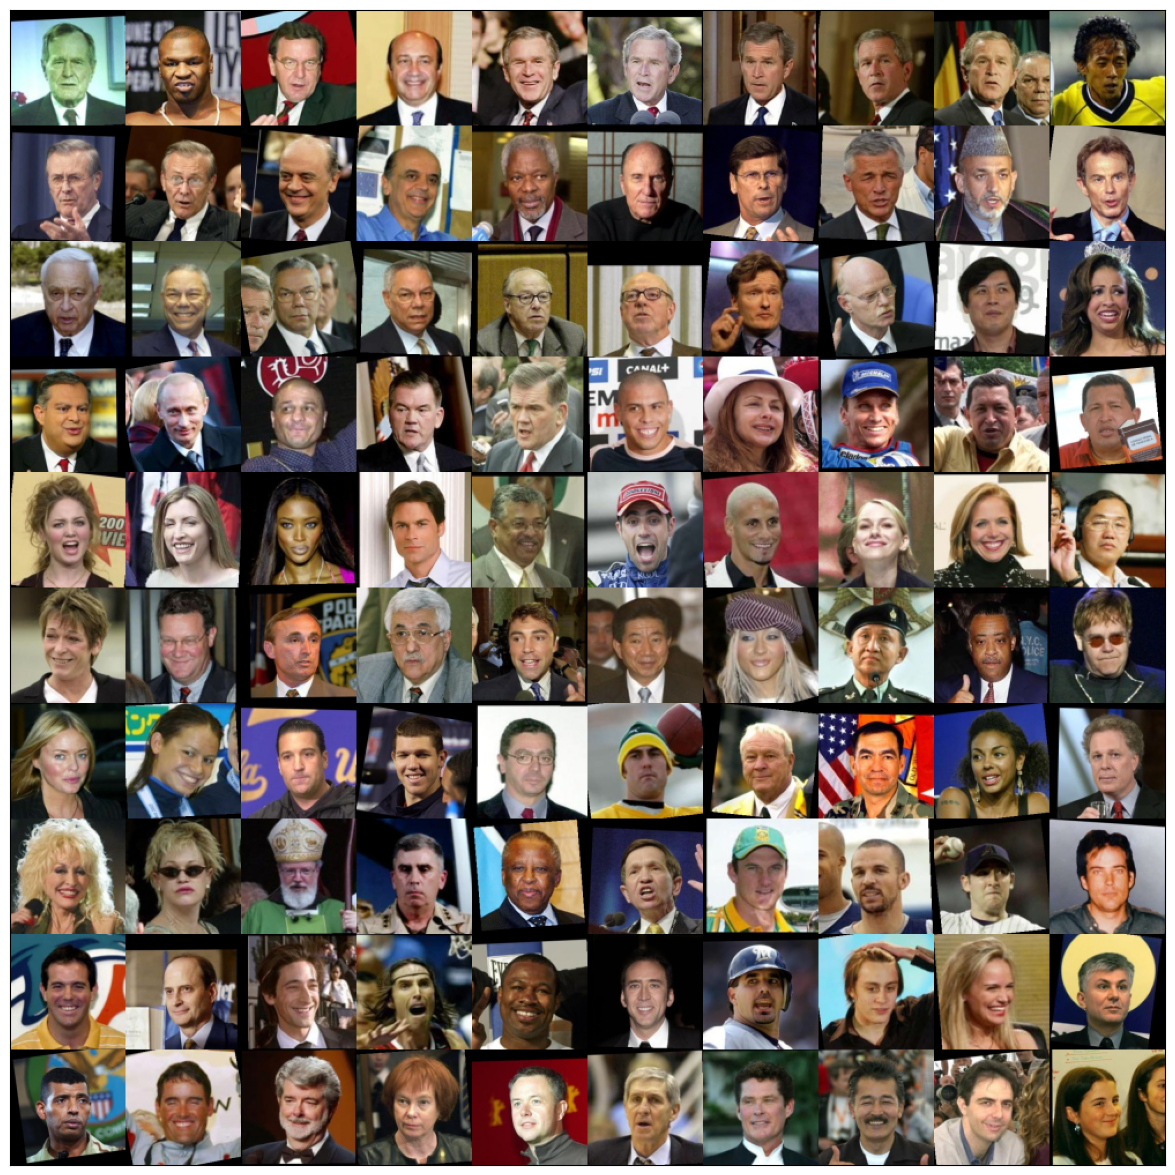

In [11]:
photo_gallery=get_photo_gallery()
print("photo_gallery:{}".format(photo_gallery.shape))
show_image(photo_gallery)

## Detecting Faces in LFW Dataset

In [16]:
frontal_cascade_path="/content/haarcascade_frontalface_default.xml"
fd=FaceDetector(frontal_cascade_path)
face_counter=0
for image_org in images:

    image_gray=cv2.cvtColor(image_org,cv2.COLOR_BGR2GRAY)
    faceRect=fd.detect(image_gray,
                       scaleFactor=1.1,
                       minNeighbors=5,
                       minSize=(30,30))
    #print("I found {} faces".format(len(faceRect)))
    first_detection=False
    for (x,y,w,h) in faceRect:
        if first_detection==False:
            face_counter+=1
            cv2.rectangle(image_org,(x,y),(x+w,y+h),(127,255,0),2)
            first_detection=True
        else:
            print("Second detection ignored in a image")

print("{} images have been scaned".format(dimension*dimension))
print("{} faces have been detected".format(face_counter))

Second detection ignored in a image
Second detection ignored in a image
Second detection ignored in a image
100 images have been scaned
95 faces have been detected


### Showing Detected Faces as Photo Gallery

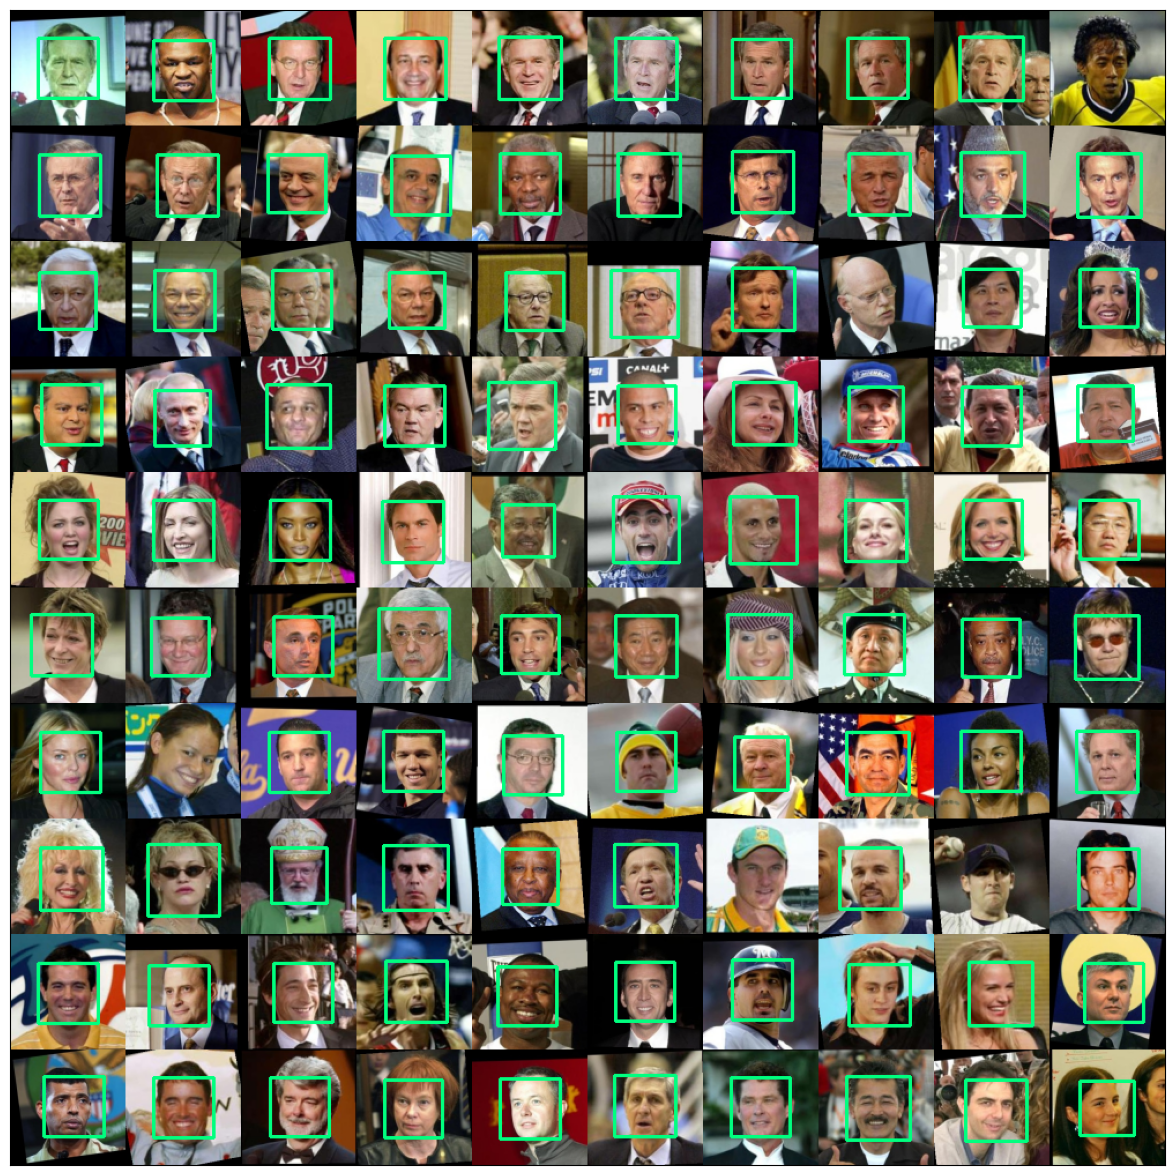

In [17]:
photo_gallery=get_photo_gallery()
show_image(photo_gallery)

# Face Detection Using Webcam

In [ ]:
"""Start webcam"""

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
image_file = take_photo()

## Read, Rezise and Show Image

In [ ]:
image = cv2.imread(image_file)
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

## download pre-trained model

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [ ]:
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

## detection loop

In [ ]:
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

## show resulting image

In [ ]:
cv2_imshow(image)